<h1>Cuenca de Providencia</h1> 
    <h3>Modelos hidrológicos grj4 y milc </h3>
    <h3> Integrantes:</h3>
    <t1> Juan Miguel Víquez </t1>
        <t1> Katherine Urbina </t1>
            <t1> Esmeralda Vargas</t1>
                <t1> Dania Zúñiga </t1>
        

<h3> Características generales: geofísicas y geológicas</h3>
<t1> La subcuenca Providencia se ubica en la cuenca del Río Savegre. La cuenca del Río Savegre tiene un área de drenaje de 603, 73 km2. La parte alta de la cuenca corresponde a la subcuenca Providencia que es drenada por el río Brujo.</t1>

<t1>Las unidades geológicas de la subcuenca corresponden a rocas ígneas y rocas sedimentarias (Rojas, 2011). Las rocas ígneas se caracterizan por una permeabilidad cercana  a 0 cuando se encuentran en un estado inalterado (Coppo, et al. 2012)</t1>

<t1>El bosque pluvial montano y el bosque muy húmedo montano bajo son las zonas de vida ubicadas en la subcuenca Providencia (Rojas, 2011). Esta subcuenca se caracteriza por encontrarse dentro del manejo de área protegida, pues una importante área de la misma está dentro del Parque Nacional Los Quetzales. </t1>

<t1>Sus características climatológicas indican que existe un promedio de precipitación anual de 2000 - 4000 mm al año, con una época lluviosa que se extiende desde abril a diciembre y una época seca de enero a marzo. En cuanto a la temperatura media anual en la subcuenca se encuentra de 8 a 12°C. La evapotranspiración anual es de aproximadamente 1000 m (Rojas, 2011).</t1>

<t1>Entre las actividades productivas de la subcuenca se destacan el ecoturismo y las plantaciones de café. A nivel turístico existe un importante desarrollo económico debido al parque nacional mencionado.</t1>




    

<h3>Modelo GR4J para la cuenca de Providencia</h3>

<t1> Paquetes utilizados</t1>

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gr4j_model import* 
from milc_model import *
import metrics as ms
import model_evaluation as me

from scipy.optimize import minimize

# Para activar a graficas interactivas reemplazar "inline" por "qt"
%matplotlib inline

<t1>Datos generales de la cuenca<t1>

In [79]:
area    = 122   # area en km2
latitud = 9.57   # latitud aprox de la cuenca

<t1> Series de tiempo extraídas de climate engine<t1>

In [112]:
 datos = pd.read_csv("./all_gr4j.csv", index_col=[0], parse_dates=[0])

<t1> Obetención de los datos de caudal<t1>

In [114]:
area = 122   # area de la cuenca en km2
qobs = datos["qt"] 

<h4>Modelo GR4J</h4>
<t2>El modelo GR4J es uno de los modelos más simples y se ha demostrado que tiene la capacidad de simular el proceso de precipitación-escorrentía en el paso del tiempo diario. Este modelo ha sido ampliamente utilizado en la simulación secuencial de la humedad del suelo y los datos del flujo en modelos conceptuales de precipitación-escorrentía obteniendo resultados muy satisfactorios.

En la modelación hidrológica, la función objetivo más comúnmente utilizada es la métrica de Eficiencia de Nash-Sutcliffe que minimiza el error cuadrático medio entre los flujos de flujo modelados y observados, métrica usada por los modelos en estudio GR2M y GR4J. La validación tiene un sentido mucho más estricto que se le atribuye al proceso de demostrar la capacidad del modelo para desempeñarse fuera de su período de capacitación
El modelo GR4J es sencillo de aplicar en comparación con modelos más complejos de entender, debido a que con estos no se tiene control de todas las variables y parámetros. A su vez la cantidad de parámetros que tiene el modelo GR4J hace que este sea más sencillo de optimizar y aumenta significativamente su eficiencia.<t2>
    
    


In [115]:
model = GR4J(area, latitud)
print(model)



______________GR4J structure______________
Catchment properties:
    Area (km2): 122.000
    Latitude  : 9.5700
Model Parameters:
    x1  > Maximum production capacity (mm)     : 1.000
    x2  > Discharge parameter (mm)             : 1.000
    x3  > Routing maximum capacity (mm)        : 1.000
    x4  > Delay (days)                         : 1.000
    ps0 > Initial production storage (psto/x1) : 1.000
    rs0 > Initial routing storage (rsto/x3)    : 0.500



<h3>Calibración manual<h3>

Metricas del modelo
Calibración KGE: 0.703, NSE: 0.446
 Validación KGE: 0.614, NSE: 0.372


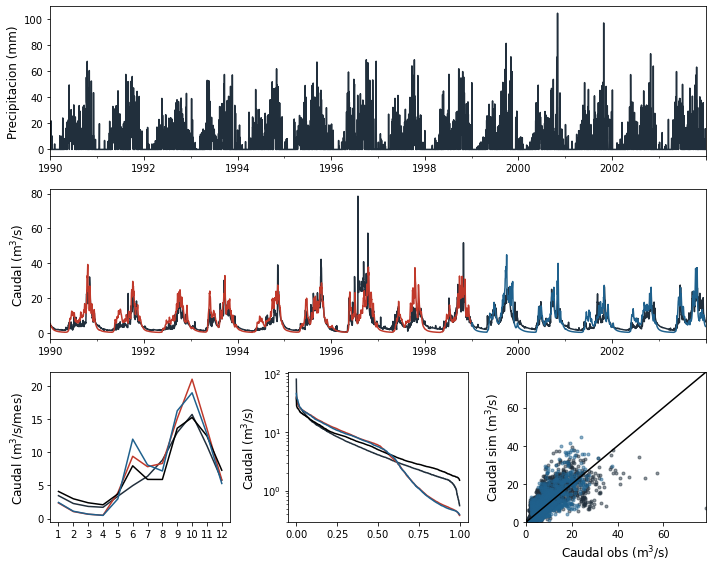

In [131]:
### 
x1=200
x2=1
x3=500
x4=5
ps0=0.5
rs0=0.5


# Fechas para dividir periodos de calibracion y validacion
fecha1 = "1990-01-01"   # fecha inicial calibracion
fecha2 = "1999-01-01"   # fecha final calibracion, inicial validacion
fecha3 = "2003-12-31"   # fecha final validacion

################# SIMULACION CON EL MODELO ###########################
######### EN ESTA INSTRUCCION DEBEN MODIFICAR LA XXXX POR CADA PARAMETRO, COMO SE HIZO EN CLASE CON EL OTRO MODELO
simulacion = model.run(datos, x1=x1,x2=x2,x3=x3,x4=x4,ps0=ps0,rs0=rs0)
qsim = simulacion.Qt

# Evaluacion del modelo
# calibracion
qobs_cal = qobs.loc[fecha1:fecha2]
qsim_cal = qsim.loc[fecha1:fecha2]
kge_cal = ms.kling_gupta_efficiency(qobs_cal, qsim_cal)
nse_cal = ms.nash_sutcliffe_efficiency(qobs_cal, qsim_cal)
# validacion
qobs_val = qobs.loc[fecha2:fecha3]
qsim_val = qsim.loc[fecha2:fecha3]
kge_val = ms.kling_gupta_efficiency(qobs_val, qsim_val)
nse_val = ms.nash_sutcliffe_efficiency(qobs_val, qsim_val)

print("Metricas del modelo")
print("Calibración KGE: {:.3f}, NSE: {:.3f}".format(kge_cal, nse_cal))
print(" Validación KGE: {:.3f}, NSE: {:.3f}".format(kge_val, nse_val))

# Graficar evaluacion
prec = datos.prec  # extraer precipitacion
fig, ax = me.plot_model_evaluation(prec, qobs, qsim, fecha1, fecha2, fecha3)

<h3>Calibración automática<h3>

In [118]:
# Ejemplo de la definición de una función objetivo

def funcion_objetivo(params):
    
    
    ################# AQUI DEBEN DEFINIR COMO EXTRAER LOS VALORES DEL VECTOR params
    x1 = params[0]
    x2    = params[1]
    x3  = params[2]
    x4 = params[3]
    ps0   = params[4]
    rs0   = params[5]
    ################# AQUI DEBEN DEFINIR COMO EXTRAER INGRESAR ESOS PARAMETROS AL MODELO
    simulacion = model.run(
        datos.loc[fecha1:fecha2, :],
        x1=x1,
        x2=x2,
        x3=x3,
        x4=x4,
        ps0=ps0,
        rs0=rs0
    )
    
    # variables a ser comparadas
    ysim = simulacion.Qt
    yobs = qobs.loc[fecha1:fecha2]
    
    # calculo del error
    error = ms.kling_gupta_efficiency(yobs, ysim)
    
    # necesitamos maximizar nse, pero los algoritmos de optimizacion
    # minimizan el valor de la funcion, asi que hay que invertir el signo
    return -error 

In [134]:
################# AQUI DEBEN DEFINIR LOS VALORES INICIALES DE LOS PARAMETROS
x0 = [
    200,#x1
    1,#x2
    500,#x3
    3,#x4
    0.5,#ps0
    0.5,#rs0
]

################# AQUI DEBEN DEFINIR LOS VALORES MINIMO Y MAXIMO DE LOS PARAMETROS (minimo, maximo)


bnds = [
    (1, 1500),        # x1
    (-10, 5),    # x2
    (1, 500),   # x3
    (0.5, 5),       # x4
    (0.001, 0.99),     #ps0
    (0.001, 0.99)
]


optim = minimize(
    funcion_objetivo,       # funcion objetivo
    x0,                     # valores iniciales
    method='TNC',         # algoritmo de optimizacion ('SLSQP', 'Powell', 'TNC', 'L-BFGS-B')
    tol=1e-5,               # tolerancia de la simulacion
    bounds=bnds,            # restricciones de parametros
    options={'disp': True}  # imprimir resumen
)

print(model)



______________GR4J structure______________
Catchment properties:
    Area (km2): 122.000
    Latitude  : 9.5700
Model Parameters:
    x1  > Maximum production capacity (mm)     : 210.999
    x2  > Discharge parameter (mm)             : -5.130
    x3  > Routing maximum capacity (mm)        : 500.000
    x4  > Delay (days)                         : 0.500
    ps0 > Initial production storage (psto/x1) : 0.486
    rs0 > Initial routing storage (rsto/x3)    : 0.473



Metricas del modelo
Calibración KGE: 0.757, NSE: 0.520
 Validación KGE: 0.670, NSE: 0.374


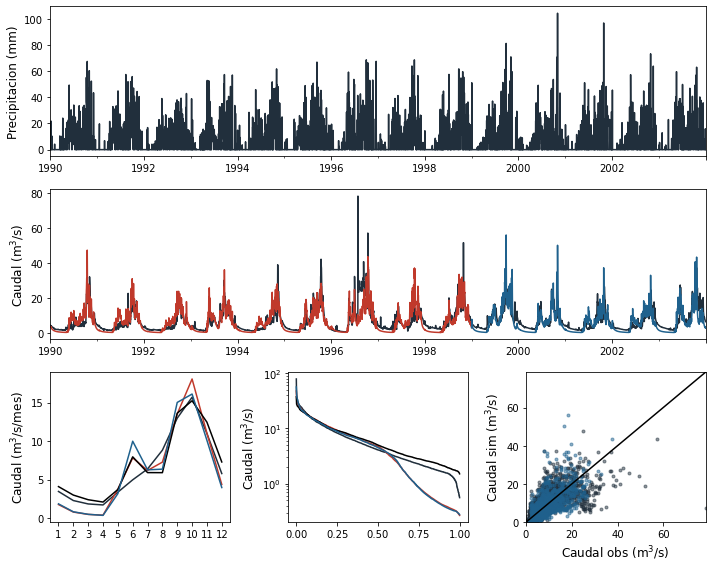

In [135]:
################# SIMULACION CON EL MODELO ###########################
simulacion = model.run(datos)
qsim = simulacion.Qt

# Evaluacion del modelo
# calibracion
qobs_cal = qobs.loc[fecha1:fecha2]
qsim_cal = qsim.loc[fecha1:fecha2]
kge_cal = ms.kling_gupta_efficiency(qobs_cal, qsim_cal)
nse_cal = ms.nash_sutcliffe_efficiency(qobs_cal, qsim_cal)
# validacion
qobs_val = qobs.loc[fecha2:fecha3]
qsim_val = qsim.loc[fecha2:fecha3]
kge_val = ms.kling_gupta_efficiency(qobs_val, qsim_val)
nse_val = ms.nash_sutcliffe_efficiency(qobs_val, qsim_val)

print("Metricas del modelo")
print("Calibración KGE: {:.3f}, NSE: {:.3f}".format(kge_cal, nse_cal))
print(" Validación KGE: {:.3f}, NSE: {:.3f}".format(kge_val, nse_val))

# Graficar evaluacion
prec = datos.prec  # extraer precipitacion
fig, ax = me.plot_model_evaluation(prec, qobs, qsim, fecha1, fecha2, fecha3)

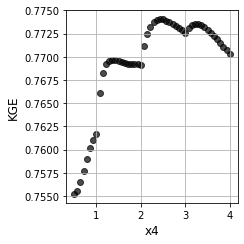

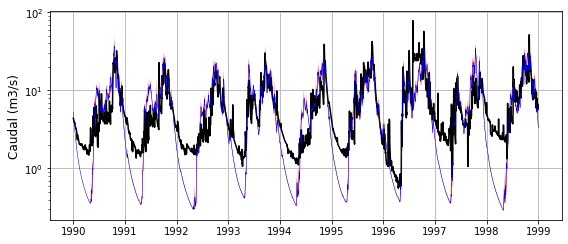

In [171]:
parametros = {
    "x1":210,
    "x2": -3.20179,
    "x3": 500,
    "x4": 2.452717,
    "ps0": 0.5,
    "rs0": 0.5,
}

# Fechas para dividir periodos de calibracion y validacion
fecha1 = "1990-01-01"   # fecha inicial calibracion
fecha2 = "1999-01-01"   # fecha final calibracion, inicial validacion

# Crear modelo con valores iniciales
modelo = GR4J(area, latitud, params=parametros)


################# SIMULACIONES AL VARIAR UN PARAMETRO ###########################
vmin      = 0.5       # valor minimo
vmax      = 4       # valor maximo
muestras  = 50        # numero de elementos
parametro = "x4"   # nombre del parametro que vamos a modificar


simulaciones  = []    # aqui vamos a guardar las simulaciones de caudal
errores       = []    # aqui vamos a guardar los valores del error
valores_param = np.linspace(vmin, vmax, muestras)  # este es nuestro vector de parametro que vamos a cambiar 

for valor in valores_param:
    # Simulamos unicamete para el periodo de calibracion
    # Modificamos unicamente el parametro que nos interesa
    nuevo_parametro = {parametro: valor}
    sim = modelo.run(datos.loc[fecha1:fecha2, :], **nuevo_parametro)
    qsim = sim.Qt

    # Evaluacion del modelo para el periodo de calibracion
    qobs = qobs.loc[fecha1:fecha2]
    kge  = ms.kling_gupta_efficiency(qobs, qsim)
    
    # Guardar elementos
    errores.append(kge)
    simulaciones.append(qsim)

# Crear dataframe de simulaciones
qsim = pd.concat(simulaciones, axis=1)   # unir en columnas
errores = np.array(errores)              # convertir a array

# Graficar variacion del error
fig1, ax1 = plt.subplots(figsize=(3.5, 3.5))
ax1.scatter(valores_param, errores, color="k", alpha=0.7)
ax1.set_xlabel(parametro, fontsize=12)
ax1.set_ylabel("KGE", fontsize=12)
ax1.grid(True)

fig1.tight_layout()

# Graficar series de tiempo
fig2, ax2 = plt.subplots(figsize=(8, 3.5))
qminimo = qsim.min(axis=1)  # minimo para cada renglon
qmedio  = qsim.mean(axis=1) # promedio para cada renglon
qmaximo = qsim.max(axis=1)  # maximo para cada renglon

fechas = qsim.index.to_pydatetime()
ax2.fill_between(fechas, qminimo, qmaximo, facecolor="r", alpha=0.8)
ax2.plot(fechas, qobs, color="k", label="Observado")
ax2.plot(fechas, qmedio, color="b", linewidth=0.5, label="Promedio simulado")
ax2.set_ylabel("Caudal (m3/s)", fontsize=12)
ax2.grid(True)
ax2.set_yscale("log")

fig2.tight_layout()

<h3>Monte Carlo<h3>

,x2,x4,kge
95,-3.905041,2.700629,0.772823
78,-4.091399,2.545040,0.772599
74,-2.709552,2.700310,0.772172
85,-3.854084,3.488780,0.771767
53,-3.910182,3.476568,0.771589
64,-2.516089,3.207063,0.771488
25,-4.093483,3.488873,0.770651
51,-2.821539,4.310088,0.770033
52,-4.603865,2.172254,0.769509
88,-3.887863,1.826834,0.769435


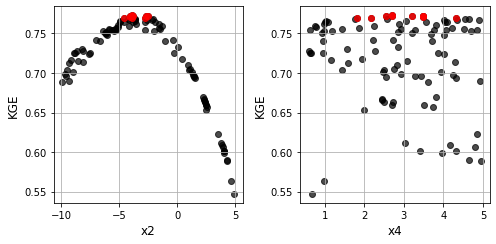

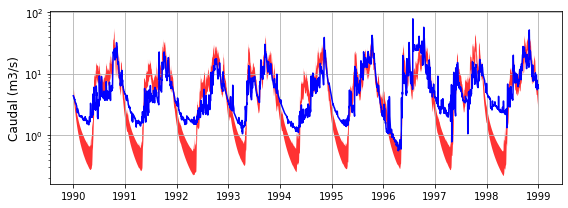

In [140]:
################# CREAR MODELO BASE ###########################
# Definicion de parametros
parametros_iniciales = {
    "x1":210,
    "x2": -3.20179,
    "x3": 500,
    "x4": 2.452717,
    "ps0": 0.5,
    "rs0": 0.5,
}

# Fechas para dividir periodos de calibracion y validacion
fecha1 = "1990-01-01"   # fecha inicial calibracion
fecha2 = "1999-01-01"   # fecha final calibracion, inicial validacion

# Crear modelo con valores iniciales
modelo = GR4J(area, latitud, params=parametros_iniciales)


################# SIMULACIONES AL VARIAR UN PARAMETRO ###########################
muestras   = 100       # numero de elementos
mejores_resultsdos = 10  # numero de los mejores resultados a mostrar
# diccionario con los parametros que queremos modificar
# indicar parametro: (vmin, vmax)
parametros = {
    "x2": (-10, 5),
    "x4": (0.5, 5),
}


npar = len(parametros) # numero de parametros que seran modificados
simulaciones  = []     # aqui vamos a guardar las simulaciones de caudal
errores       = []     # aqui vamos a guardar los valores del error

# Crear matrices vacias para guardar los parametros generados
# valores de parametros para graficar
valores_aleatorios = pd.DataFrame(
    np.zeros((muestras, npar)),
    columns=parametros.keys()
)
# valores de parametros durante iteracion
nuevo_parametro = {}
for key in parametros.keys():
    vmin = parametros[key][0]
    vmax = parametros[key][1]
    valores_aleatorios.loc[:, key] = np.random.uniform(vmin, vmax, muestras)
    
    nuevo_parametro[key] = 0.0

    
for i in range(muestras):
    # Simulamos unicamete para el periodo de calibracion
    for key in parametros.keys():
        # guardar valores para simular
        nuevo_parametro[key] = valores_aleatorios.loc[i, key]
    
    # Simulamos unicamete para el periodo de calibracion
    sim = modelo.run(datos.loc[fecha1:fecha2, :], **nuevo_parametro)
    qsim = sim.Qt

    # Evaluacion del modelo para el periodo de calibracion
    qobs = qobs.loc[fecha1:fecha2]
    kge  = ms.kling_gupta_efficiency(qobs, qsim)
    
    # Guardar elementos
    errores.append(kge)
    simulaciones.append(qsim)

# Crear dataframe de simulaciones
qsim = pd.concat(simulaciones, axis=1)   # unir en columnas
valores_aleatorios["kge"] = np.array(errores) # agregar columna con el error
# ordenar parametros de mayor a menor kge
parametros_ordenados = valores_aleatorios.sort_values(by="kge", ascending=False)
parametros_ordenados = parametros_ordenados.iloc[:mejores_resultsdos, :]

# Graficar variacion del error
ancho = 3.5 * npar
fig, ax = plt.subplots(ncols=npar, figsize=(ancho, 3.5))
ax = ax.flatten()
for i in range(npar):
    parametro = valores_aleatorios.columns[i]
    # graficar todos los parametros
    ax[i].scatter(
        valores_aleatorios.loc[:, parametro],   # valores en x
        valores_aleatorios.loc[:, "kge"],       # valores en y
        color="k",                              # color de puntos
        alpha=0.7                               # transparencia
    )
    # graficar parametros de mejor ajuste
    ax[i].scatter(
        parametros_ordenados.loc[:, parametro], # valores en x
        parametros_ordenados.loc[:, "kge"],     # valores en y
        color="r",                              # color de puntos
        alpha=0.8                               # transparencia
    )
    
    ax[i].set_xlabel(parametro, fontsize=12)
    ax[i].set_ylabel("KGE", fontsize=12)
    ax[i].grid(True)

fig.tight_layout()    

# Graficar series de tiempo
fig2, ax2 = plt.subplots(figsize=(8, 3))
qminimo = qsim.min(axis=1)  # minimo para cada renglon
qmedio  = qsim.mean(axis=1) # promedio para cada renglon
qmaximo = qsim.max(axis=1)# maximo para cada renglon

fechas = qsim.index.to_pydatetime()
ax2.fill_between(fechas, qminimo, qmaximo, facecolor="r", alpha=0.8)
ax2.plot(fechas,qobs,color="b", label="Observado")
#ax2.plot(fechas, qmedio, color="r", linewidth=0.5, label="Promedio simulado")
ax2.set_ylabel("Caudal (m3/s)", fontsize=12)
ax2.set_yscale("log")
ax2.grid(True)
fig2.tight_layout()

# Mostrar parametros de mejor ajuste
parametros_ordenados

<T1>Datos para modelo MILc<T1>

In [157]:
datosMILc = pd.read_csv("./all_milc.csv", index_col=[0], parse_dates=[0])

<t1> Obetención de los datos de caudal<t1>

In [158]:
qobs = datosMILc["Qt"] 

In [159]:
qobs

Date
1990-01-01    4.40
1990-01-02    4.33
1990-01-03    4.33
1990-01-04    4.19
1990-01-05    4.13
              ... 
2003-12-27    7.25
2003-12-28    7.03
2003-12-29    6.81
2003-12-30    6.60
2003-12-31    6.50
Name: Qt, Length: 5113, dtype: float64

<H3>Modelo MILc</H3>
<t1>Características del modelo MILc<t1>

In [160]:
modelo_MILc = MILc(area, latitud)
print(modelo_MILc)



______________MILC structure______________
Catchment properties:
    Area (km2): 122.000
    Latitude  : 9.5700
Model Parameters:
    gamma > routing coefficient (adim)               : 1.000
    w0    > Initial Water Content (adim)             : 0.500
    wmax  > Maximum Water Capacity (mm)              : 1.000
    alpha > Runoff parameter (adim)                  : 1.000
    kc    > Vegetation/Crop Coeficient (adim)        : 1.000
    m     > Drainage exponent (adim)                 : 1.000
    ks    > Satured hydraulic conductivity (mm/hr)   : 1.000
    nu    > Fraction of drainage vs interflow (adim) : 1.000



<H4>Calibración manual</H4>

Metricas del modelo
Calibración KGE: -0.360, NSE: -0.776
 Validación KGE: -0.342, NSE: -1.276


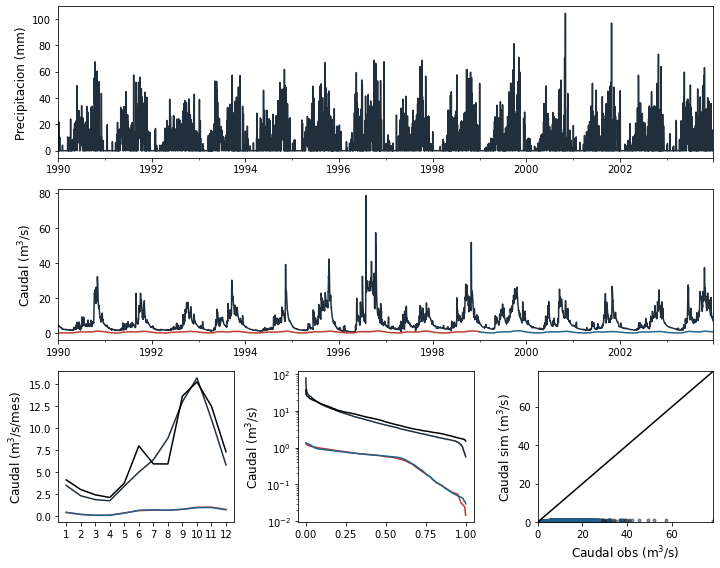

In [161]:
################# DATOS DEL USUARIO ###########################
# Definicion de parametros
gamma = 500
w0    = 0.5
wmax  = 200
alpha = 5
kc    = 1.0
ks    = 10 
m     = 2
nu    = 0.9

# Fechas para dividir periodos de calibracion y validacion
fecha1 = "1990-01-01"   # fecha inicial calibracion
fecha2 = "1999-01-01"   # fecha final calibracion, inicial validacion
fecha3 = "2003-12-31"   # fecha final validacion

################# SIMULACION CON EL MODELO ###########################
simulacion = modelo_MILc.run(datosMILc, gamma=gamma, w0=w0, wmax=wmax, alpha=alpha, kc=kc, ks=ks, m=m, nu=nu)
qsim = simulacion.Qt

# Evaluacion del modelo
# calibracion
qobs_cal = qobs.loc[fecha1:fecha2]
qsim_cal = qsim.loc[fecha1:fecha2]
kge_cal = ms.kling_gupta_efficiency(qobs_cal, qsim_cal)
nse_cal = ms.nash_sutcliffe_efficiency(qobs_cal, qsim_cal)
# validacion
qobs_val = qobs.loc[fecha2:fecha3]
qsim_val = qsim.loc[fecha2:fecha3]
kge_val = ms.kling_gupta_efficiency(qobs_val, qsim_val)
nse_val = ms.nash_sutcliffe_efficiency(qobs_val, qsim_val)

print("Metricas del modelo")
print("Calibración KGE: {:.3f}, NSE: {:.3f}".format(kge_cal, nse_cal))
print(" Validación KGE: {:.3f}, NSE: {:.3f}".format(kge_val, nse_val))

# Graficar evaluacion
prec = datosMILc.prec  # extraer precipitacion
fig, ax = me.plot_model_evaluation(prec, qobs, qsim, fecha1, fecha2, fecha3)

<h3>Calibración automática<h3>

In [165]:
def funcion_objetivo(params):
    
    # Extraer los parametros del vector de entrada
    gamma = params[0]
    w0    = params[1]
    wmax  = params[2]
    alpha = params[3]
    kc    = params[4]
    ks    = params[5]
    m     = params[6]
    nu    = params[7]
    
    simulacion = modelo_MILc.run(
        datosMILc.loc[fecha1:fecha2, :],
        gamma=gamma,
        w0=w0,
        wmax=wmax,
        alpha=alpha,
        kc=kc,
        ks=ks,
        m=m,
        nu=nu
    )
    
    # variables a ser comparadas
    ysim = simulacion.Qt
    yobs = qobs.loc[fecha1:fecha2]
    
    # calculo del error
    error = ms.kling_gupta_efficiency(yobs, ysim)
    
    # necesitamos maximizar nse, pero los algoritmos de optimizacion
    # minimizan el valor de la funcion, asi que hay que invertir el signo
    return -error 

In [166]:
x0 = [
    2,     # gamma
    0.5,   # w0
    800,   # wmax
    5,     # alpha
    1,     # kc
    100,    # ks
    10,    # m
    0.4,   # nu
]

# definir limites de los parametros (minimo, maximo)
bnds = [
    (1, 5),        # gamma
    (0.1, 0.9),    # w0
    (100, 1000),   # wmax
    (2, 5),       # alpha
    (0.5, 2),      # kc
    (10, 200),      # ks
    (5, 20),     # m
    (0.01, 0.99),  # nu
]

optim = minimize(
    funcion_objetivo,       # funcion objetivo
    x0,                     # valores iniciales
    method='L-BFGS-B',         # algoritmo de optimizacion ('SLSQP', 'Powell', 'TNC', 'L-BFGS-B')
    tol=1e-5,               # tolerancia de la simulacion
    bounds=bnds,            # restricciones de parametros
    options={'disp': True}  # imprimir resumen
)

print(modelo_MILc)



______________MILC structure______________
Catchment properties:
    Area (km2): 122.000
    Latitude  : 9.5700
Model Parameters:
    gamma > routing coefficient (adim)               : 2.006
    w0    > Initial Water Content (adim)             : 0.566
    wmax  > Maximum Water Capacity (mm)              : 800.010
    alpha > Runoff parameter (adim)                  : 4.999
    kc    > Vegetation/Crop Coeficient (adim)        : 0.500
    m     > Drainage exponent (adim)                 : 9.957
    ks    > Satured hydraulic conductivity (mm/hr)   : 100.013
    nu    > Fraction of drainage vs interflow (adim) : 0.010



Metricas del modelo
Calibración KGE: 0.493, NSE: 0.346
 Validación KGE: 0.509, NSE: 0.161


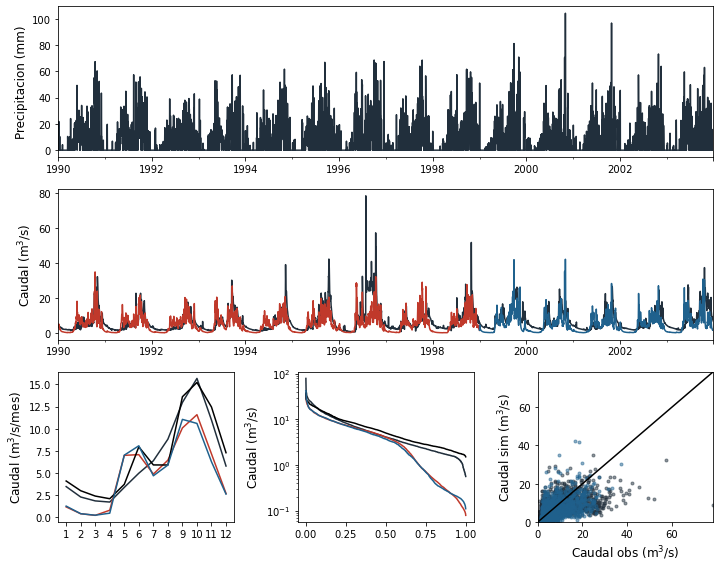

In [168]:
################# SIMULACION CON EL MODELO ###########################
simulacion = modelo_MILc.run(datosMILc)
qsim = simulacion.Qt

# Evaluacion del modelo
# calibracion
qobs_cal = qobs.loc[fecha1:fecha2]
qsim_cal = qsim.loc[fecha1:fecha2]
kge_cal = ms.kling_gupta_efficiency(qobs_cal, qsim_cal)
nse_cal = ms.nash_sutcliffe_efficiency(qobs_cal, qsim_cal)
# validacion
qobs_val = qobs.loc[fecha2:fecha3]
qsim_val = qsim.loc[fecha2:fecha3]
kge_val = ms.kling_gupta_efficiency(qobs_val, qsim_val)
nse_val = ms.nash_sutcliffe_efficiency(qobs_val, qsim_val)

print("Metricas del modelo")
print("Calibración KGE: {:.3f}, NSE: {:.3f}".format(kge_cal, nse_cal))
print(" Validación KGE: {:.3f}, NSE: {:.3f}".format(kge_val, nse_val))

# Graficar evaluacion
prec = datosMILc.prec  # extraer precipitacion
fig, ax = me.plot_model_evaluation(prec, qobs, qsim, fecha1, fecha2, fecha3)

<h4>Análisis de Sensibilidad<h4>

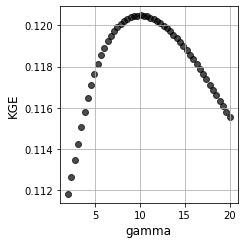

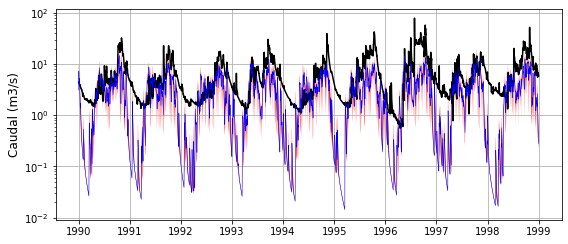

In [169]:
parametros = {
    "gamma": 5,
    "w0": 0.5,
    "wmax": 800,
    "alpha": 0.4,
    "kc": 1.0,
    "ks": 20,
    "m": 2,
    "nu": 0.8
}

# Fechas para dividir periodos de calibracion y validacion
fecha1 = "1990-01-01"   # fecha inicial calibracion
fecha2 = "1999-01-01"   # fecha final calibracion, inicial validacion

# Crear modelo con valores iniciales
modelo = MILc(area, latitud, params=parametros)


################# SIMULACIONES AL VARIAR UN PARAMETRO ###########################
vmin      = 2         # valor minimo
vmax      = 20        # valor maximo
muestras  = 50        # numero de elementos
parametro = "gamma"   # nombre del parametro que vamos a modificar


simulaciones  = []    # aqui vamos a guardar las simulaciones de caudal
errores       = []    # aqui vamos a guardar los valores del error
valores_param = np.linspace(vmin, vmax, muestras)  # este es nuestro vector de parametro que vamos a cambiar 

for valor in valores_param:
    # Simulamos unicamete para el periodo de calibracion
    # Modificamos unicamente el parametro que nos interesa
    nuevo_parametro = {parametro: valor}
    sim = modelo.run(datosMILc.loc[fecha1:fecha2, :], **nuevo_parametro)
    qsim = sim.Qt

    # Evaluacion del modelo para el periodo de calibracion
    qobs = qobs.loc[fecha1:fecha2]
    kge  = ms.kling_gupta_efficiency(qobs, qsim)
    
    # Guardar elementos
    errores.append(kge)
    simulaciones.append(qsim)

# Crear dataframe de simulaciones
qsim = pd.concat(simulaciones, axis=1)   # unir en columnas
errores = np.array(errores)              # convertir a array

# Graficar variacion del error
fig1, ax1 = plt.subplots(figsize=(3.5, 3.5))
ax1.scatter(valores_param, errores, color="k", alpha=0.7)
ax1.set_xlabel(parametro, fontsize=12)
ax1.set_ylabel("KGE", fontsize=12)
ax1.grid(True)

fig1.tight_layout()

# Graficar series de tiempo
fig2, ax2 = plt.subplots(figsize=(8, 3.5))
qminimo = qsim.min(axis=1)  # minimo para cada renglon
qmedio  = qsim.mean(axis=1) # promedio para cada renglon
qmaximo = qsim.max(axis=1)  # maximo para cada renglon

fechas = qsim.index.to_pydatetime()
ax2.fill_between(fechas, qminimo, qmaximo, facecolor="r", alpha=0.8)
ax2.plot(fechas, qobs, color="k", label="Observado")
ax2.plot(fechas, qmedio, color="b", linewidth=0.5, label="Promedio simulado")
ax2.set_ylabel("Caudal (m3/s)", fontsize=12)
ax2.grid(True)
ax2.set_yscale("log")

fig2.tight_layout()

<h3>Monte Carlo<h3>

,gamma,alpha,kge
0,12.483348,1.075807,0.212899
45,3.244542,1.349035,0.192928
44,14.657767,1.383658,0.189673
48,13.077293,1.483715,0.185230
33,19.992030,1.559859,0.179252
12,16.384821,1.629854,0.178117
43,2.020664,1.741446,0.176315
28,2.665037,1.759118,0.175951
38,26.478683,1.592331,0.175311
20,8.339939,2.103409,0.168945


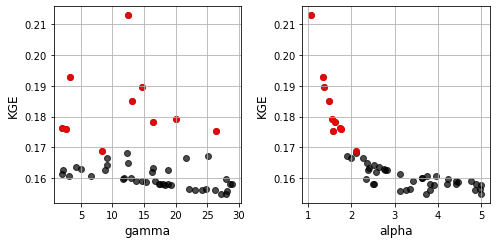

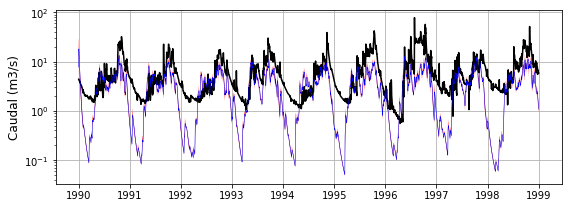

In [174]:
parametros_iniciales = {
    "gamma": 5,
    "w0": 0.5,
    "wmax": 800,
    "alpha": 0.4,
    "kc": 1.0,
    "ks": 20,
    "m": 2,
    "nu": 0.4
}

# Fechas para dividir periodos de calibracion y validacion
fecha1 = "1990-01-01"   # fecha inicial calibracion
fecha2 = "1999-01-01"   # fecha final calibracion, inicial validacion

# Crear modelo con valores iniciales
modelo = MILc(area, latitud, params=parametros_iniciales)


################# SIMULACIONES AL VARIAR UN PARAMETRO ###########################
muestras   = 50         # numero de elementos
mejores_resultsdos = 10  # numero de los mejores resultados a mostrar
# diccionario con los parametros que queremos modificar
# indicar parametro: (vmin, vmax)
parametros = {
    "gamma": (2, 30),
    "alpha": (1, 5),
}


npar = len(parametros) # numero de parametros que seran modificados
simulaciones  = []     # aqui vamos a guardar las simulaciones de caudal
errores       = []     # aqui vamos a guardar los valores del error

# Crear matrices vacias para guardar los parametros generados
# valores de parametros para graficar
valores_aleatorios = pd.DataFrame(
    np.zeros((muestras, npar)),
    columns=parametros.keys()
)
# valores de parametros durante iteracion
nuevo_parametro = {}
for key in parametros.keys():
    vmin = parametros[key][0]
    vmax = parametros[key][1]
    valores_aleatorios.loc[:, key] = np.random.uniform(vmin, vmax, muestras)
    
    nuevo_parametro[key] = 0.0

    
for i in range(muestras):
    # Simulamos unicamete para el periodo de calibracion
    for key in parametros.keys():
        # guardar valores para simular
        nuevo_parametro[key] = valores_aleatorios.loc[i, key]
    
    # Simulamos unicamete para el periodo de calibracion
    sim = modelo.run(datosMILc.loc[fecha1:fecha2, :], **nuevo_parametro)
    qsim = sim.Qt

    # Evaluacion del modelo para el periodo de calibracion
    qobs = qobs.loc[fecha1:fecha2]
    kge  = ms.kling_gupta_efficiency(qobs, qsim)
    
    # Guardar elementos
    errores.append(kge)
    simulaciones.append(qsim)

# Crear dataframe de simulaciones
qsim = pd.concat(simulaciones, axis=1)   # unir en columnas
valores_aleatorios["kge"] = np.array(errores) # agregar columna con el error
# ordenar parametros de mayor a menor kge
parametros_ordenados = valores_aleatorios.sort_values(by="kge", ascending=False)
parametros_ordenados = parametros_ordenados.iloc[:mejores_resultsdos, :]

# Graficar variacion del error
ancho = 3.5 * npar
fig, ax = plt.subplots(ncols=npar, figsize=(ancho, 3.5))
ax = ax.flatten()
for i in range(npar):
    parametro = valores_aleatorios.columns[i]
    # graficar todos los parametros
    ax[i].scatter(
        valores_aleatorios.loc[:, parametro],   # valores en x
        valores_aleatorios.loc[:, "kge"],       # valores en y
        color="k",                              # color de puntos
        alpha=0.7                               # transparencia
    )
    # graficar parametros de mejor ajuste
    ax[i].scatter(
        parametros_ordenados.loc[:, parametro], # valores en x
        parametros_ordenados.loc[:, "kge"],     # valores en y
        color="r",                              # color de puntos
        alpha=0.8                               # transparencia
    )
    
    ax[i].set_xlabel(parametro, fontsize=12)
    ax[i].set_ylabel("KGE", fontsize=12)
    ax[i].grid(True)

fig.tight_layout()    

# Graficar series de tiempo
fig2, ax2 = plt.subplots(figsize=(8, 3))
qminimo = qsim.min(axis=1)  # minimo para cada renglon
qmedio  = qsim.mean(axis=1) # promedio para cada renglon
qmaximo = qsim.max(axis=1)  # maximo para cada renglon

fechas = qsim.index.to_pydatetime()
ax2.fill_between(fechas, qminimo, qmaximo, facecolor="r", alpha=0.8)
ax2.plot(fechas, qobs, color="k", label="Observado")
ax2.plot(fechas, qmedio, color="b", linewidth=0.5, label="Promedio simulado")
ax2.set_ylabel("Caudal (m3/s)", fontsize=12)
ax2.set_yscale("log")
ax2.grid(True)
fig2.tight_layout()

# Mostrar parametros de mejor ajuste
parametros_ordenados